# KAIST Summer Session 2018

## MNIST Classifier using Convolutional Neural Network (with inception) (08.20.2018)

- MNIST dataset (Modified National Institute of Standards and Technology database) has ten classes of handwritten digits from 0 to 9.

### 0. Data Preparation

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt


# Training settings
batch_size = 64

# MNIST Dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = torchvision.datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

- Let's look inside the MNIST dataset

       6     7     5     5     7     3     3     8
       3     4     7     2     2     0     2     8
       7     0     5     4     9     7     8     2
       1     7     0     9     8     5     4     3
       8     3     7     9     2     7     9     3
       2     7     8     2     5     4     7     8
       4     9     1     5     7     4     5     6
       1     5     0     8     8     2     7     0


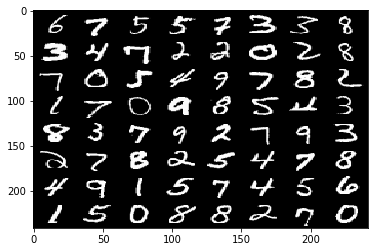

In [47]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), aspect='auto')


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

for i in range(8):
    print('  ', ' '.join('%5s' % classes[labels[j+i*8]] for j in range(8)))
    i += 1

### 1. Define a Neural Network
- Add dropout
- Add inception

In [48]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(88, 20, kernel_size=5)
        self.incept1 = Inception(in_channels=10)
        self.incept2 = Inception(in_channels=20)
        self.dropout = nn.Dropout2d(0.1)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(1408, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.incept1(x)
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.incept2(x)
        x = self.dropout(x)
        x = x.view(-1, 1408)
        x = self.fc(x)
        return x

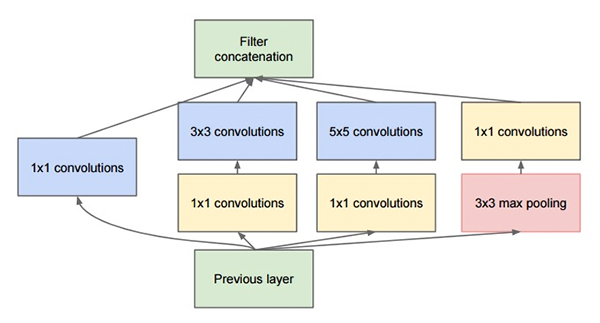

In [49]:
class Inception(nn.Module):

    def __init__(self, in_channels):
        super(Inception, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)

        self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3dbl_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)

        branch_pool = self.pool(x)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

### 2. Define a Loss Function and Optimizer

In [50]:
# Instantiate CNN model
model = CNN()

# Set loss and optimizer function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

### 3. Training

In [51]:
n_epochs = 2

for epoch in range(1, n_epochs+1):     
    # Training
    model.train()    # set model in training mode (required for dropout)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = torch.tensor(data), torch.tensor(target)
                  
        output = model(data)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    
print("Learning finished!")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312015
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.851394
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.400210
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.414417
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.225990
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.231122
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.110448
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.277357
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.255921
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.058478
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.179591
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.272213
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.151934
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.128253
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.059622
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.040947
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.078068
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.223876
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.193760
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.135903
Learning fin

### 4. Evaluation

In [55]:
# Evaluation
model.eval()    # set model in test mode (required for dropout)
    
test_loss = 0
correct = 0
for data, target in test_loader:
    data, target = torch.tensor(data), torch.tensor(target)
    output = model(data)
    # sum up batch loss
    test_loss += criterion(output, target).data.item()
    # get the index of the max
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

test_loss /= len(test_loader.dataset)
print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0011, Accuracy: 9762/10000 (97%)



- Let's see how the model works well


        --------Truth-------- 

       7     2     1     0     4     1     4     9
       5     9     0     6     9     0     1     5
       9     7     3     4     9     6     6     5
       4     0     7     4     0     1     3     1
       3     4     7     2     7     1     2     1
       1     7     4     2     3     5     1     2
       4     4     6     3     5     5     6     0
       4     1     9     5     7     8     9     3

        ------Predicted------ 

       7     2     1     0     4     1     4     9
       5     9     0     6     9     0     1     5
       9     7     8     4     9     6     6     5
       4     0     7     4     0     1     3     1
       3     4     7     2     7     1     2     1
       1     7     4     2     3     5     1     2
       4     4     6     3     5     5     6     0
       4     1     9     5     7     8     9     3


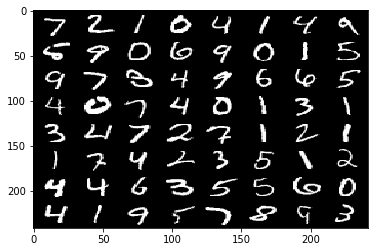

In [53]:
# get some random test images
dataiter_test = iter(test_loader)
images_test, labels_test = dataiter_test.next()

# show images
imshow(torchvision.utils.make_grid(images_test))

print('\n       ', '--------Truth--------', '\n')
for i in range(8):
    print('  ', ' '.join('%5s' % classes[labels_test[j+i*8]] for j in range(8)))
    i += 1
    
    
output = model(images_test)
_, predicted = torch.max(output, 1)

print('\n       ', '------Predicted------', '\n')
for i in range(8):
    print('  ', ' '.join('%5s' % classes[predicted[j+i*8]] for j in range(8)))
    i += 1